In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from transformer_pipeline import drop_rows, get_features_transformer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, HDBSCAN #it is avaliable since 1.3 version
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from metrics import *
from custom_preprocessors import IdentityTransformer
import sklearn
from sklearn.model_selection import train_test_split
from dimensionality_reduction_and_explanation_tools import *
import warnings
warnings.filterwarnings("ignore")

In [145]:
data = pd.read_csv("data/movie_statistic_dataset.csv")
df, val = train_test_split(data, test_size=0.2, random_state=14)
df = drop_rows(df)

In [146]:
dim_red_funs = [get_nmf_plots,get_pca_plots,get_tsne_plots]

In [182]:
def assign_color(cluster):
    colors = {
        -1: 'white', 0: 'red', 1: 'blue', 2: 'green', 3: 'yellow', 4: 'purple',
        5: 'orange', 6: 'pink', 7: 'brown', 8: 'gray', 9: 'cyan',
        10: 'magenta', 11: 'lime', 12: 'maroon', 13: 'navy', 14: 'olive',
        15: 'gold', 16: 'teal', 17: 'violet', 18: 'khaki', 19: 'coral',
        20: 'turquoise', 21: 'orchid', 22: 'salmon', 23: 'plum',
        24: 'red', 25: 'blue', 26: 'green', 27: 'yellow', 28: 'purple',
        29: 'orange', 30: 'pink', 31: 'brown', 32: 'gray', 33: 'cyan',
        34: 'magenta', 35: 'lime', 36: 'maroon', 37: 'navy', 38: 'olive',
        39: 'gold', 40: 'teal', 41: 'violet', 42: 'khaki', 43: 'coral',
        44: 'turquoise', 45: 'orchid', 46: 'salmon', 47: 'plum',
        48: 'red', 49: 'blue', 50: 'green', 51: 'yellow', 52: 'purple',
        53: 'orange', 54: 'pink', 55: 'brown', 56: 'gray', 57: 'cyan',
        58: 'magenta', 59: 'lime', 60: 'maroon', 61: 'navy', 62: 'olive',
        63: 'gold', 64: 'teal', 65: 'violet', 66: 'khaki', 67: 'coral',
        68: 'turquoise', 69: 'orchid', 70: 'salmon', 71: 'plum',
        72: 'red', 73: 'blue', 74: 'green', 75: 'yellow', 76: 'purple',
        77: 'orange', 78: 'pink', 79: 'brown', 80: 'gray', 81: 'cyan',
        82: 'magenta', 83: 'lime', 84: 'maroon', 85: 'navy', 86: 'olive',
        87: 'gold', 88: 'teal', 89: 'violet', 90: 'khaki', 91: 'coral',
        92: 'turquoise', 93: 'orchid', 94: 'salmon', 95: 'plum'
    }
    return colors.get(cluster, 'black')

# Hierarchcal clustering

In [142]:
AG_transformer = make_pipeline(get_features_transformer(PowerTransformer(method="box-cox"),
                                          PowerTransformer(method="box-cox"),
                                          StandardScaler(),
                                          StandardScaler()), MinMaxScaler())
AG_X = AG_transformer.fit_transform(df)

In [149]:
model = AgglomerativeClustering()

parameters = {
    "n_clusters": [None],
    "linkage": ['ward', 'complete', 'average', 'single'],
    "distance_threshold": uniform(1,40)}

score = {
    "silhouette_score": silhouette,
    "calinski_harabasz_score": calinski_harabasz,
    "davies_bouldin_score": davies_bouldin}

In [150]:
tester = RandomizedSearchCV(estimator=model,
                            param_distributions= parameters,
                            random_state=14, 
                            scoring=score,
                            refit='davies_bouldin_score',
                            n_iter=100,
                            cv=2) 

In [151]:
random_result = tester.fit(AG_X)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))


Best: 1.273093 using {'distance_threshold': 1.3218779411927164, 'linkage': 'ward', 'n_clusters': None}


In [209]:
# 'ward', 'complete', 'average', 'single'
model = AgglomerativeClustering(n_clusters=None, linkage='complete', distance_threshold=2.8)
y = model.fit_predict(AG_X)
model.n_clusters_
# average & single is useless

20

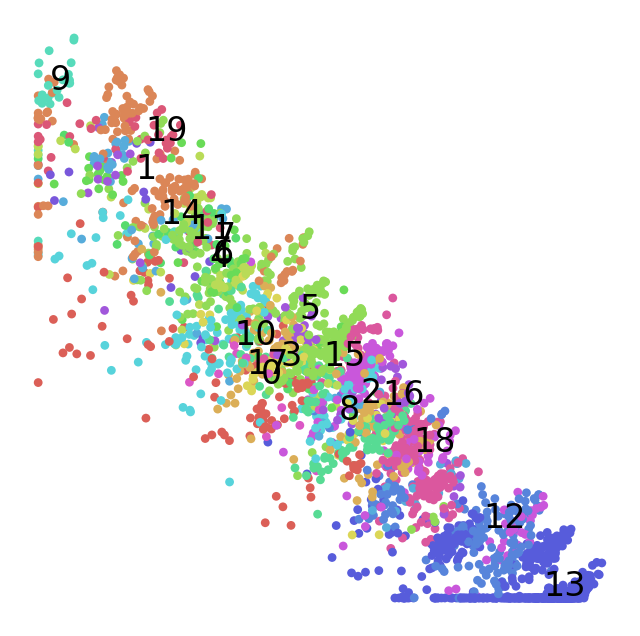

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


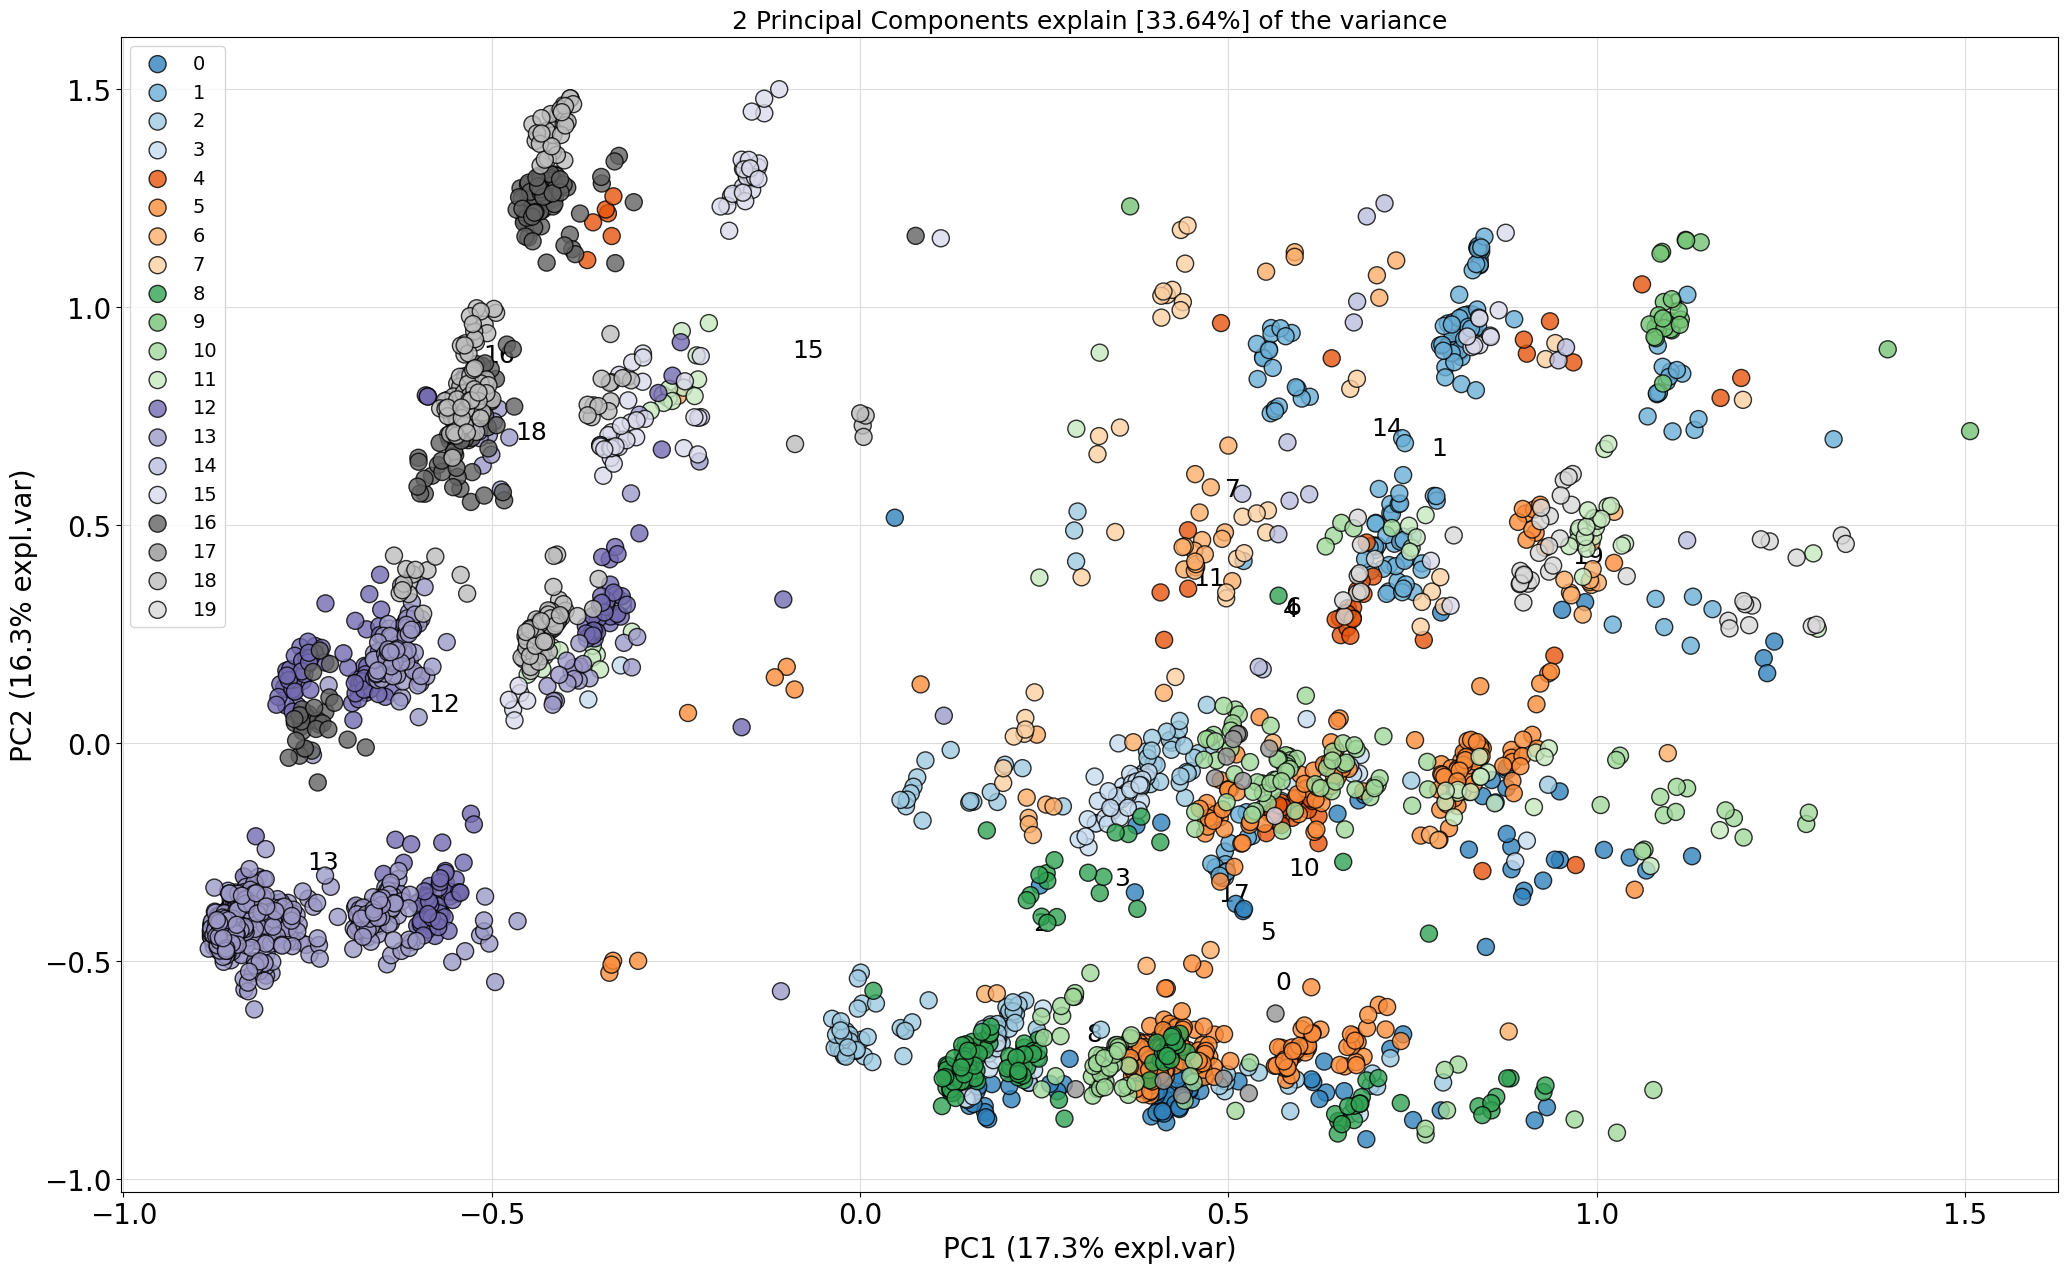

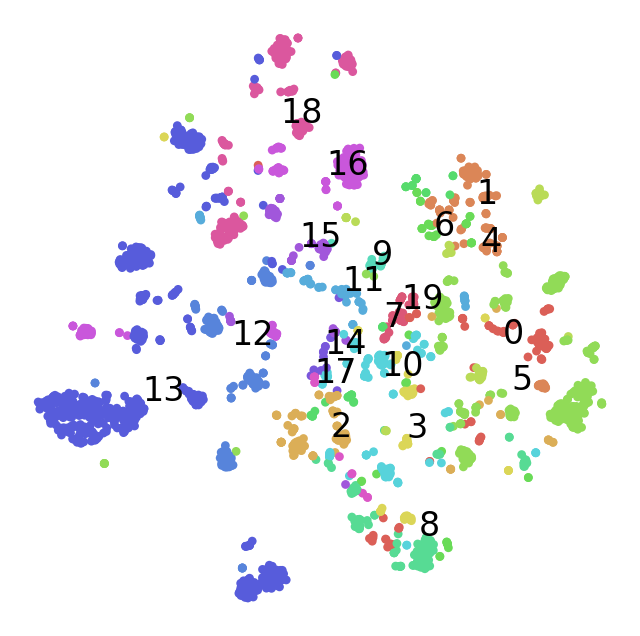

In [210]:
for fun in dim_red_funs:
    fun(AG_X,y)

In [211]:
AG_df = df.copy()
AG_df["cluster"] = y

tmp1 = AG_df.copy()
tmp1['colour'] = tmp1['cluster'].apply(assign_color)

tmp1 = tmp1.sort_values(by = "cluster")

html1 = tmp1.style.apply(lambda row: ['background-color: ' + row['colour']] * len(row), axis=1).to_html()
with open('DBSCAN.html', 'w') as f:
    f.write(html1)

In [212]:
print(f'number of films: {len(AG_df)}')
AG_df['cluster'].value_counts()

number of films: 2783


13    626
5     370
18    230
12    188
16    174
1     158
8     152
10    145
2     135
0     107
15     85
3      79
11     79
4      62
6      54
19     46
7      41
9      25
14     14
17     13
Name: cluster, dtype: int64

# DBSCAN

In [10]:
DB_transformer = make_pipeline(get_features_transformer(PowerTransformer(method="box-cox"),
                                          PowerTransformer(method="box-cox"),
                                          IdentityTransformer(),
                                          IdentityTransformer()), MinMaxScaler())
DB_X = DB_transformer.fit_transform(df)
DB_X.shape

(2783, 19)

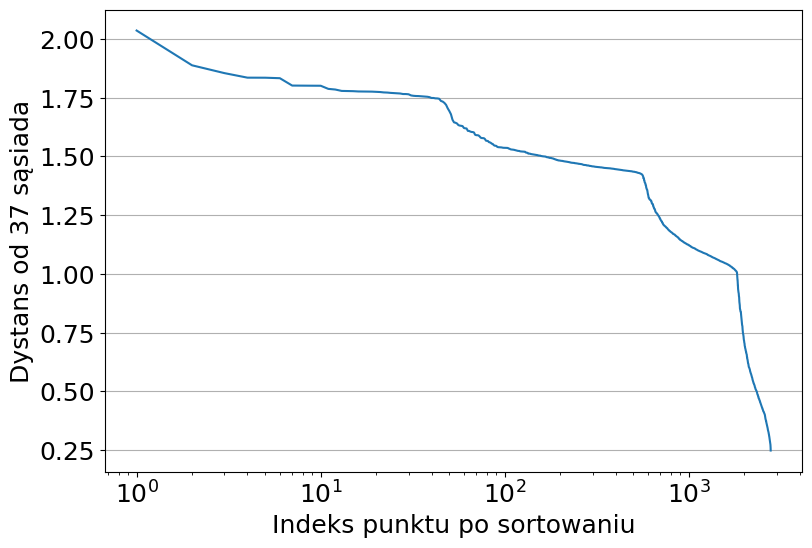

In [11]:
minPts = 38
nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=minPts).fit(DB_X)
distances, indices = nbrs.kneighbors(DB_X)
distanceDec = sorted(distances[:,minPts-1], reverse=True)
fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)

plt.xlabel('Indeks punktu po sortowaniu')
plt.ylabel('Dystans od 37 sąsiada')
ax1.plot(list(range(1,DB_X.shape[0]+1)), distanceDec)
plt.xscale('log')
plt.grid(axis='y')

plt.show()


In [12]:
#SOMETHING IS WRONG BUT IT IS THE END FOR TODAY
model = DBSCAN()
parameters = {
    "eps": uniform(0.75,2.0), #it suppose to be points with great loss on the plot but they give nan :)
    "min_samples": [minPts],
    "algorithm":['auto', 'ball_tree', 'kd_tree', 'brute']}

score = {
    "silhouette_score": silhouette,
    "calinski_harabasz_score": calinski_harabasz,
    "davies_bouldin_score": davies_bouldin}

In [13]:
tester = RandomizedSearchCV(estimator=model,
                            param_distributions= parameters,
                            random_state=14, 
                            scoring=score,
                            refit='silhouette_score',
                            n_iter=100,
                            cv=2
                            ) 

In [14]:
random_result = tester.fit(DB_X)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.229953 using {'algorithm': 'auto', 'eps': 1.699811531900937, 'min_samples': 38}


In [202]:
model = DBSCAN(min_samples= 38, eps=1.0015, algorithm= 'auto')
y = model.fit_predict(DB_X)
labels = model.labels_
# Number of clusters without a noise labeled as -1
len(set(labels)) - (1 if -1 in labels else 0)

13

how TF eps is higher than top value in uniform?


[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values


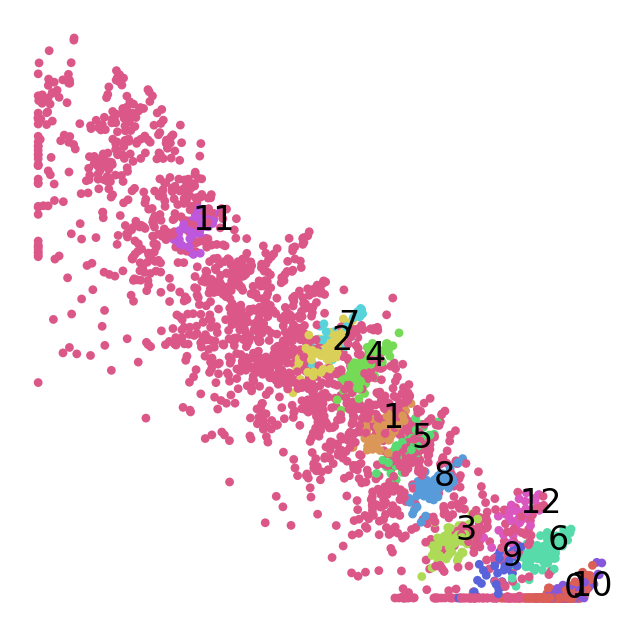

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


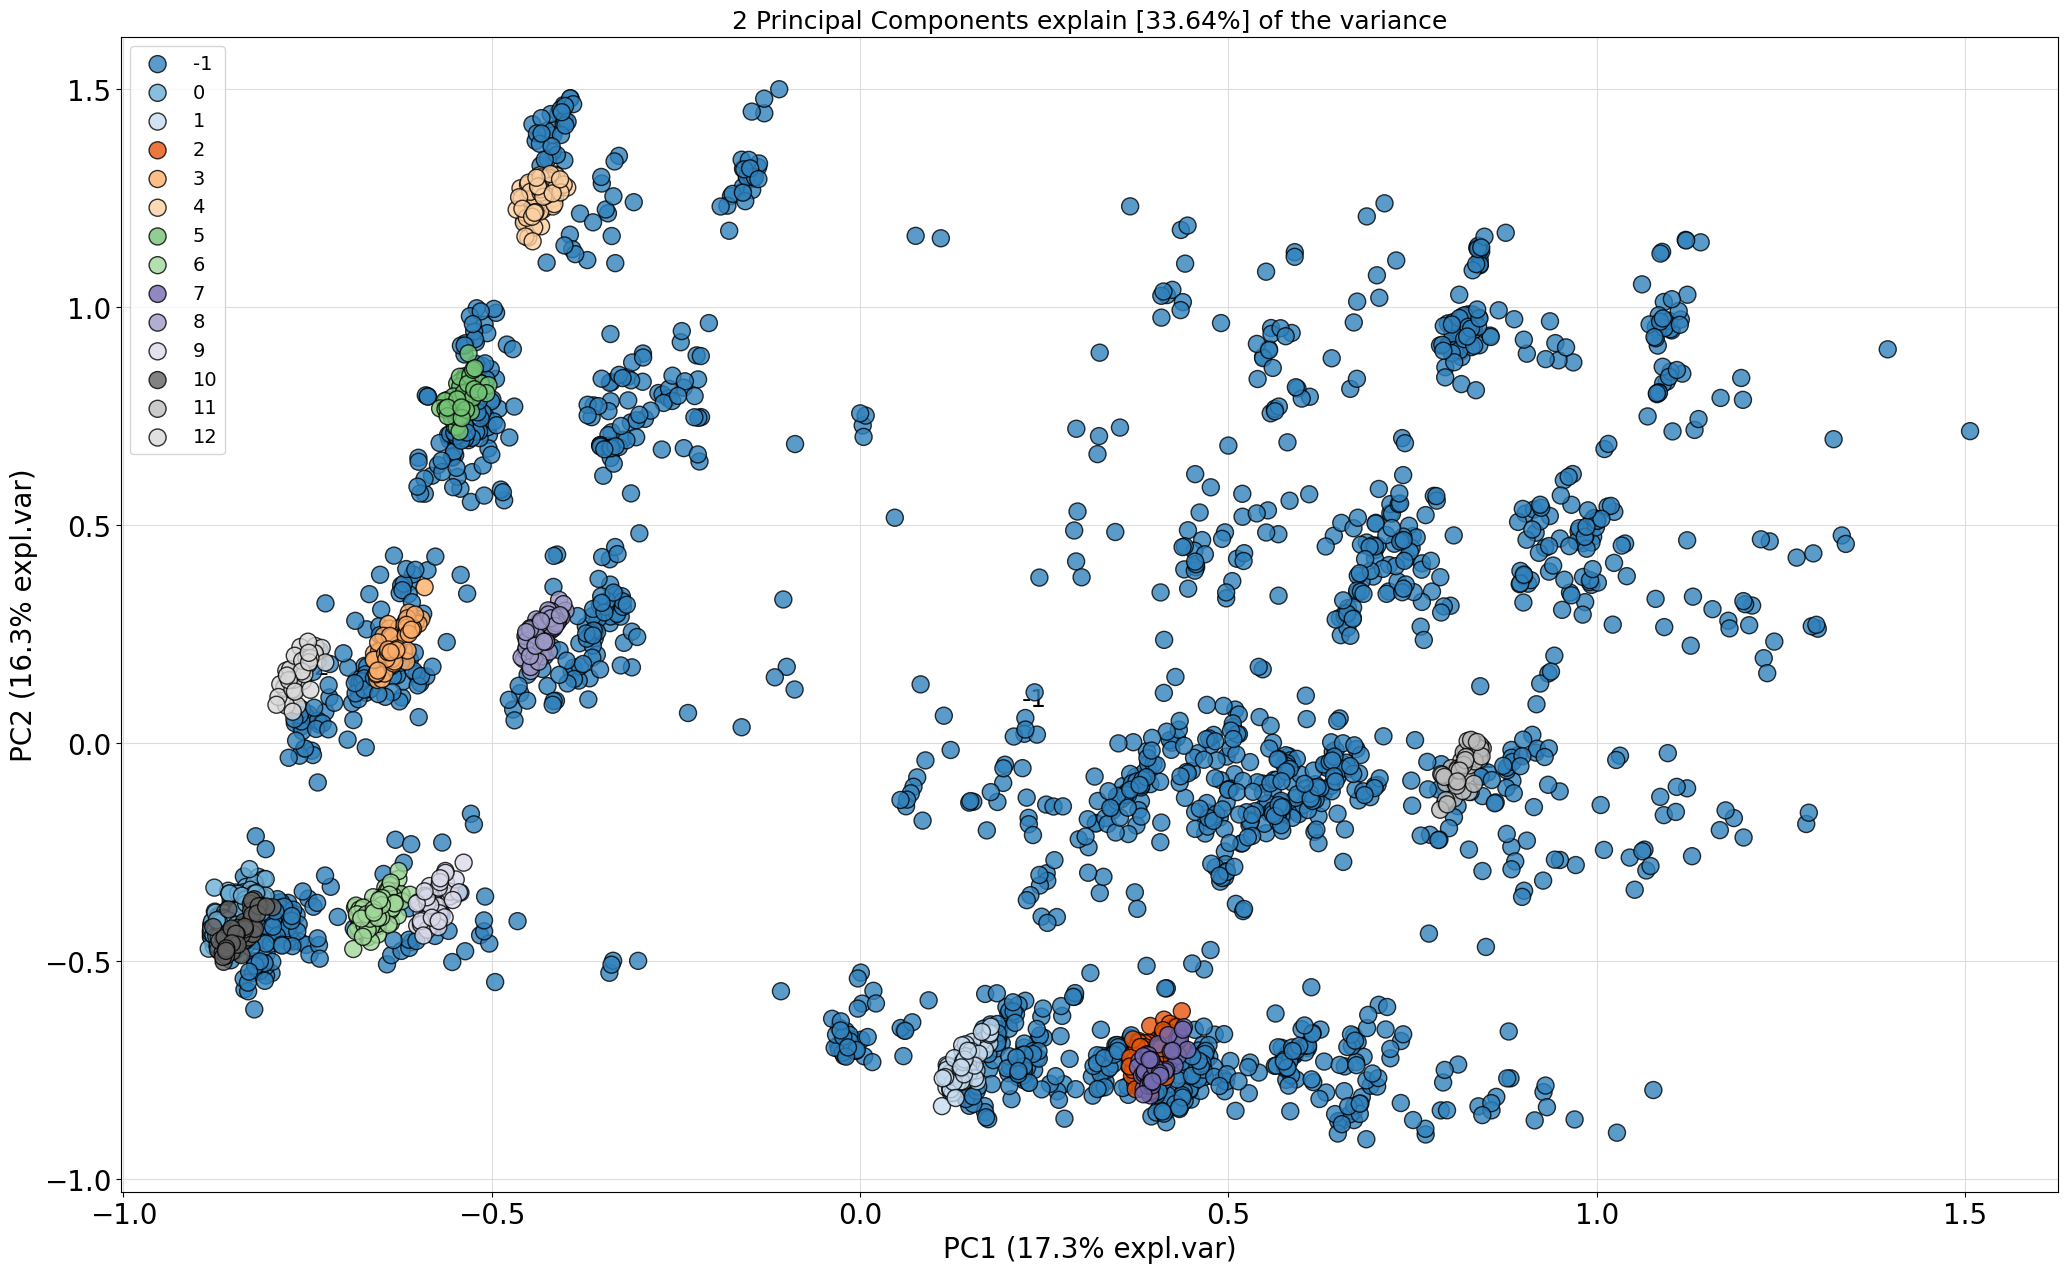

[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values


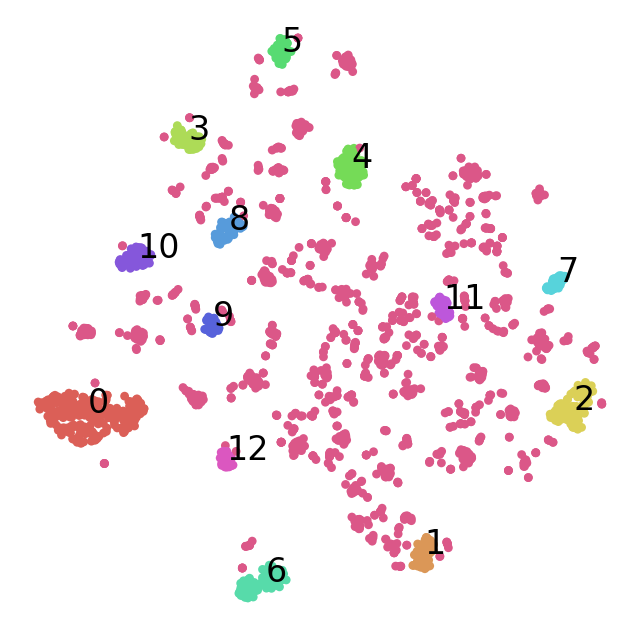

In [203]:
for fun in dim_red_funs:
    fun(DB_X,y)

In [204]:
DB_df = df.copy()
DB_df["cluster"] = y

tmp1 = DB_df.copy()
tmp1['colour'] = tmp1['cluster'].apply(assign_color)

tmp1 = tmp1.sort_values(by = "cluster")

html1 = tmp1.style.apply(lambda row: ['background-color: ' + row['colour']] * len(row), axis=1).to_html()
with open('DBSCAN.html', 'w') as f:
    f.write(html1)

In [205]:
print(f'number of films: {len(DB_df)}')
DB_df['cluster'].value_counts()

number of films: 2783


-1     1795
 0      236
 2      106
 6       94
 4       81
 10      66
 1       64
 8       63
 3       61
 5       53
 11      46
 7       41
 9       39
 12      38
Name: cluster, dtype: int64

# HDBSCAN

I JUST PREPARED THE TEMPLATE

In [17]:
HDB_transformer = make_pipeline(get_features_transformer(
    PowerTransformer(method="box-cox"),
    PowerTransformer(method="box-cox"),
    IdentityTransformer(),
    IdentityTransformer()
), MinMaxScaler())
HDB_X = HDB_transformer.fit_transform(df)

In [18]:
model = HDBSCAN()



parameters = {
    # "min_cluster_size": randint(50,1000),
    # "cluster_selection_epsilon": uniform(0,5),
    "algorithm":['auto', 'balltree', 'kdtree', 'brute']}

score = {
    "silhouette_score": silhouette,
    "calinski_harabasz_score": calinski_harabasz,
    "davies_bouldin_score": davies_bouldin}

In [19]:
tester = RandomizedSearchCV(estimator=model,
                            param_distributions= parameters,
                            random_state=14, 
                            scoring=score,
                            refit='silhouette_score',
                            n_iter=100,
                            cv=2
                            ) 

In [20]:
random_result = tester.fit(HDB_X)
print("Best: %f using %s" % (random_result.best_score_, random_result.best_params_))

Best: 0.250690 using {'algorithm': 'auto'}


In [94]:
model = HDBSCAN(min_cluster_size= 15)
y = model.fit_predict(HDB_X)
labels = model.labels_
len(set(labels)) - (1 if -1 in labels else 0)

42

[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values


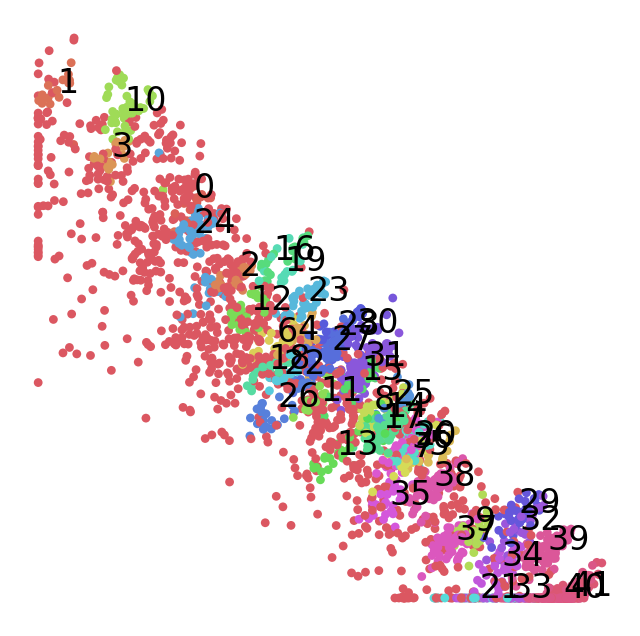

[pca] >Column labels are auto-completed.
[pca] >Row labels are auto-completed.
[pca] >The PCA reduction is performed on the [19] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


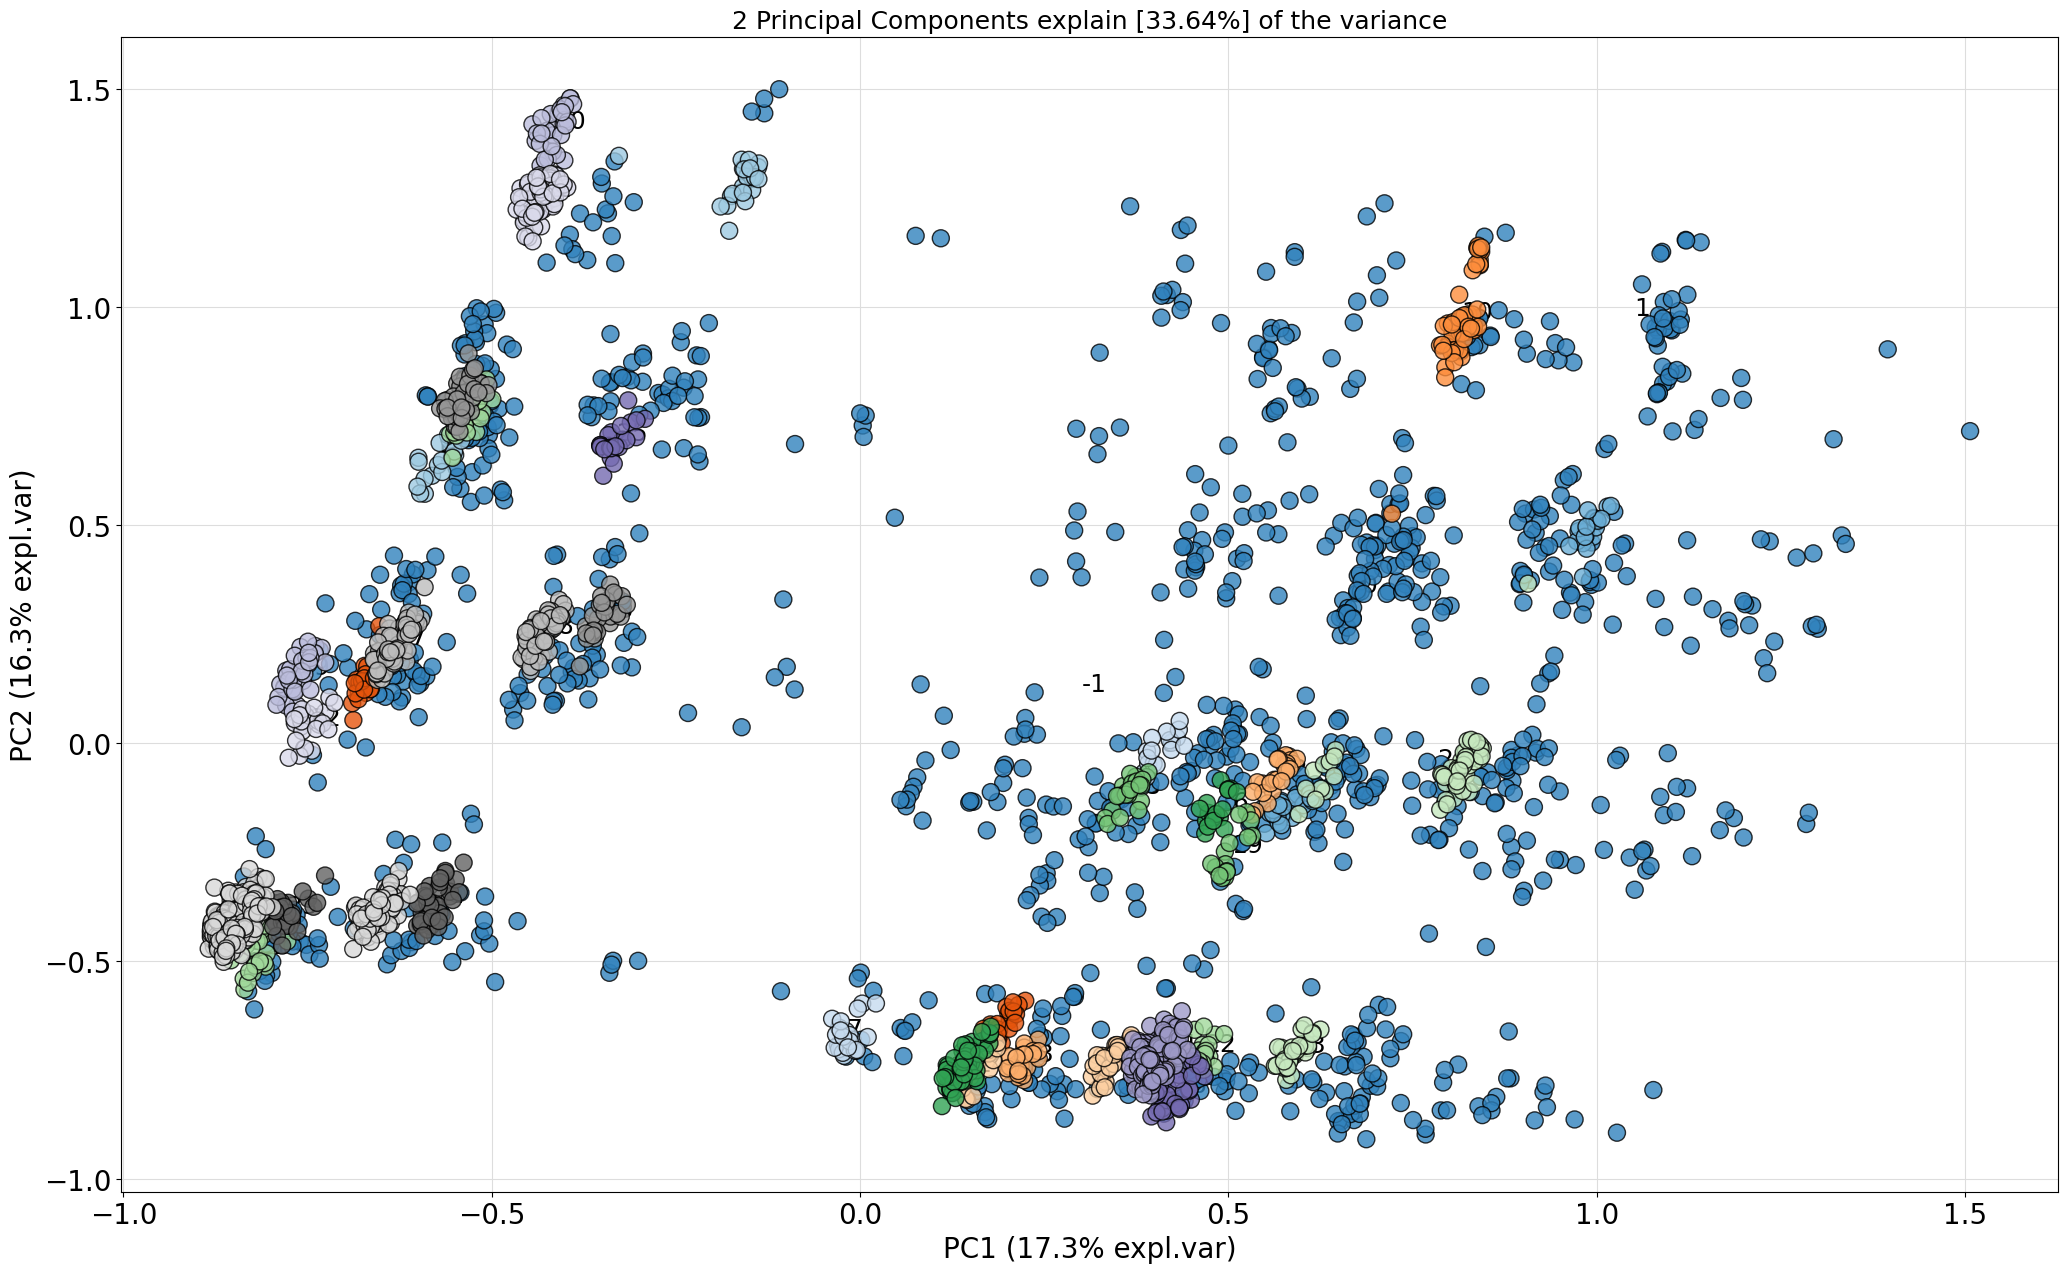

[scatterd] >WARNING> posx and posy should be finite values
[scatterd] >WARNING> posx and posy should be finite values


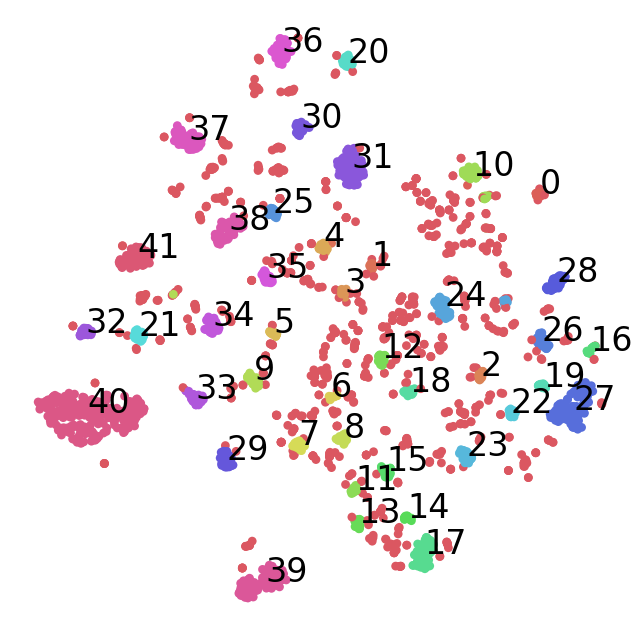

In [95]:
for fun in dim_red_funs:
    fun(HDB_X,y)

In [71]:
HDB_df = df.copy()
HDB_df["cluster"] = y

tmp1 = HDB_df.copy()
tmp1['colour'] = tmp1['cluster'].apply(assign_color)

tmp1 = tmp1.sort_values(by = "cluster")

html1 = tmp1.style.apply(lambda row: ['background-color: ' + row['colour']] * len(row), axis=1).to_html()
with open('HDBSCAN.html', 'w') as f:
    f.write(html1)

In [72]:
print(f'number of films: {len(HDB_df)}')
HDB_df['cluster'].value_counts()


number of films: 2783


-1     843
 60    236
 38    106
 57     94
 46     81
      ... 
 16     11
 49     11
 19     11
 29     10
 50     10
Name: cluster, Length: 63, dtype: int64